# Melee Data Visualizer

Convert slippi files to json (javascript). You can run this script here, or in a seperate terminal for a progress bar to appear
node './src/slippi_data_loader/main.js' 'path/to/slippiReplayDir' 'path/to/outputDir'

In [1]:
import subprocess
import sys
import time

# Define the path to the JavaScript file
js_file = '../slippi_data_loader/main.js'

# Define the arguments for the JavaScript file
slippi_dir = "C:\\Users\\Scott\\Documents\\Slippi"
output_dir = "../../data"

# Run the JavaScript file using Node.js with arguments
process = subprocess.Popen(
    ['node', js_file, slippi_dir, output_dir],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1,  # Line-buffered
    universal_newlines=True
)

# Read and print the output in real-time
while True:
    output = process.stdout.readline()
    if output == '' and process.poll() is not None:
        break
    if output:
        print(output.strip(), flush=True)
    time.sleep(0.1)  # Sleep briefly to allow the buffer to fill

# Check for any errors
err = process.stderr.read()
if err:
    print(f"Error: {err.strip()}", flush=True)


Load the json files

In [2]:
import os

# # Check the current working directory
# print("Current working directory:", os.getcwd())

from json_game_loader import JSONLoader

loader = JSONLoader(output_dir)
game_jsons = loader.load_all_jsons()

Loaded 4063 JSON files successfully.


Player

In [3]:
mainPlayerName = 'berryfairy'

In [4]:
import pandas as pd

# Assume loaded_data is the list of JSON objects you loaded using JSONLoader
# loaded_data = [...]

# Convert the list of JSON objects to a Pandas DataFrame
df = pd.json_normalize(game_jsons)

# List all column headers
headers = df.columns.tolist()

Time Played

In [5]:
from datetime import timedelta

# Step 1: Sum all the frames
total_frames = df['metadata.lastFrame'].sum()

# Step 2: Convert frames to seconds
total_seconds = total_frames / 60

# Step 3: Convert seconds to timedelta
time_delta = timedelta(seconds=total_seconds)

# Extract days, hours, minutes, and seconds from the timedelta
days, seconds = time_delta.days, time_delta.seconds
hours = seconds // 3600
minutes = (seconds % 3600) // 60
seconds = seconds % 60

# Convert total time to hours
total_hours = time_delta.total_seconds() / 3600

# Display the result
print(f"Total time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
print(f"Total time in hours: {total_hours:.2f} hours")

Total time: 8 days, 3 hours, 8 minutes, 17 seconds
Total time in hours: 195.14 hours


Remove team data

In [6]:
# Remove all rows where settings.isTeams is True
df = df[~df['settings.isTeams']]

Determine main player index

In [7]:
# Function to determine the mainPlayerIndex
def determine_main_player_index(row):
    global mainPlayerName
    players = row['settings.players']
    if players[0]['displayName'] == mainPlayerName or players[0]['userId'] == mainPlayerName:
        return 0
    elif players[1]['displayName'] == mainPlayerName or players[1]['userId'] == mainPlayerName:
        return 1
    else:
        return None

# Add the mainPlayerIndex column
df['mainPlayerIndex'] = df.apply(determine_main_player_index, axis=1)

# Remove rows where mainPlayerIndex is None
df = df[df['mainPlayerIndex'].notna()]

Stocks

In [8]:
def compute_final_stocks(stocks):
    initial_stocks = 4
    player_indices = {0: 4, 1: 4}  # Initialize with 4 stocks for each player index

    for stock in stocks:
        if stock['endPercent'] is not None:
            player_indices[stock['playerIndex']] -= 1

    return [player_indices[0], player_indices[1]]

# Apply the function to each row in the DataFrame
df['FinalStocks'] = df['stats.stocks'].apply(compute_final_stocks)

L-cancel

In [9]:
# Add a column for the L-cancel ratio
df['l_cancel_ratio'] = None

# Loop through each row using iterrows
for gameIndex, game in df.iterrows():
    playerIndex = int(game['mainPlayerIndex'])
    if pd.isna(playerIndex):  # Skip if mainPlayerIndex is NaN
        continue
    playerActionCounts = game['stats.actionCounts'][playerIndex]
    playerLcancelSuccess = playerActionCounts['lCancelCount']['success']
    playerLcancelFailure = playerActionCounts['lCancelCount']['fail']
    
    if playerLcancelSuccess + playerLcancelFailure < 5:
        continue
    
    l_cancel_ratio = playerLcancelSuccess / (playerLcancelSuccess + playerLcancelFailure)
    df.at[gameIndex, 'l_cancel_ratio'] = l_cancel_ratio

# Remove rows where l_cancel_ratio is None (i.e., playerLcancelSuccess + playerLcancelFailure was 0)
df = df[df['l_cancel_ratio'].notna()]

Wavedash

In [10]:
# Add a column for the L-cancel ratio
variable_of_interest = 'wavedashCount'
df[variable_of_interest] = None

# Loop through each row using iterrows
for gameIndex, game in df.iterrows():
    playerIndex = int(game['mainPlayerIndex'])
    if pd.isna(playerIndex):  # Skip if mainPlayerIndex is NaN
        continue
    playerActionCount = game['stats.actionCounts'][playerIndex][variable_of_interest]
    df.at[gameIndex, variable_of_interest] = playerActionCount

# Remove rows where l_cancel_ratio is None (i.e., playerLcancelSuccess + playerLcancelFailure was 0)
df = df[df[variable_of_interest].notna()]

# Plots

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings

def plot_with_moving_average_and_ci(df, column_name, mainPlayerName, window_size=10, y_lim=None):
    """
    Plot the raw data and its rolling mean with confidence interval for the given column in the DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    column_name (str): The column to plot.
    mainPlayerName (str): The name of the main player for the plot title.
    window_size (int): The window size for the moving average. Default is 10.
    """
    # Suppress FutureWarnings
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Set the aesthetic style of the plots to dark
    sns.set_style("darkgrid", {"axes.facecolor": ".1", "grid.color": ".15"})

    # Set the context for the plot (e.g., paper, notebook, talk, poster)
    sns.set_context("talk")

    # Define a color palette suitable for dark themes
    palette = sns.color_palette("magma", as_cmap=True)

    # Calculate the rolling mean and standard deviation
    df['rolling_mean'] = df[column_name].rolling(window=window_size).mean()
    df['rolling_std'] = df[column_name].rolling(window=window_size).std()

    # Calculate the confidence interval (e.g., 95% confidence interval)
    df['ci_upper'] = df['rolling_mean'] + 1.96 * df['rolling_std']
    df['ci_lower'] = df['rolling_mean'] - 1.96 * df['rolling_std']

    # Clip the lower confidence interval at 0
    df['ci_lower'] = df['ci_lower'].clip(lower=0)

    # Create subplots
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

    # Plot the raw data
    sns.lineplot(data=df, x=df.index, y=column_name, marker='o', markersize=6, linewidth=2, color=palette(0.9), alpha=0.7, ax=axes[0])
    # axes[0].set_title(f'{column_name.replace("_", " ").capitalize()} Per Game', fontsize=20, weight='bold', color='white')
    axes[0].set_xlabel('Game Index', fontsize=16, color='white')
    axes[0].set_ylabel(column_name.replace("_", " ").capitalize(), fontsize=16, color='white')
    axes[0].tick_params(axis='x', colors='white', labelsize=12)
    axes[0].tick_params(axis='y', colors='white', labelsize=12)
    axes[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    axes[0].patch.set_facecolor('#1e1e1e')
    axes[0].spines['top'].set_color('none')
    axes[0].spines['right'].set_color('none')
    axes[0].spines['left'].set_color('white')
    axes[0].spines['bottom'].set_color('white')
    if y_lim is not None:
        axes[0].set_ylim(y_lim)  # Set y-axis range

    # Plot the moving average with confidence interval
    sns.lineplot(data=df, x=df.index, y='rolling_mean', linewidth=2, color=palette(0.5), alpha=0.7, ax=axes[1], label='Rolling Mean')
    axes[1].fill_between(df.index, df['ci_lower'], df['ci_upper'], color=palette(0.5), alpha=0.3, label='95% Confidence Interval')
    # axes[1].set_title(f'{column_name.replace("_", " ").capitalize()} Per Game (Moving Average with Confidence Interval)', fontsize=20, weight='bold', color='white')
    axes[1].set_xlabel('Game Index', fontsize=16, color='white')
    axes[1].set_ylabel(column_name.replace("_", " ").capitalize(), fontsize=16, color='white')
    axes[1].tick_params(axis='x', colors='white', labelsize=12)
    axes[1].tick_params(axis='y', colors='white', labelsize=12)
    axes[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    axes[1].patch.set_facecolor('#1e1e1e')
    axes[1].spines['top'].set_color('none')
    axes[1].spines['right'].set_color('none')
    axes[1].spines['left'].set_color('white')
    axes[1].spines['bottom'].set_color('white')
    if y_lim is not None:
        axes[1].set_ylim(y_lim)  # Set y-axis range

    # Add legend to the second subplot
    legend = axes[1].legend(loc='upper right', fontsize=12)
    for text in legend.get_texts():
        text.set_color('white')

    # Customize the figure background
    fig.patch.set_facecolor('#1e1e1e')

    # Add a larger title to the figure
    fig.suptitle(f'{mainPlayerName} {column_name.replace("_", " ").capitalize()}', fontsize=24, weight='bold', color='white')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 1, 0.97])

    # Show the plot
    plt.show()

### L-cancel

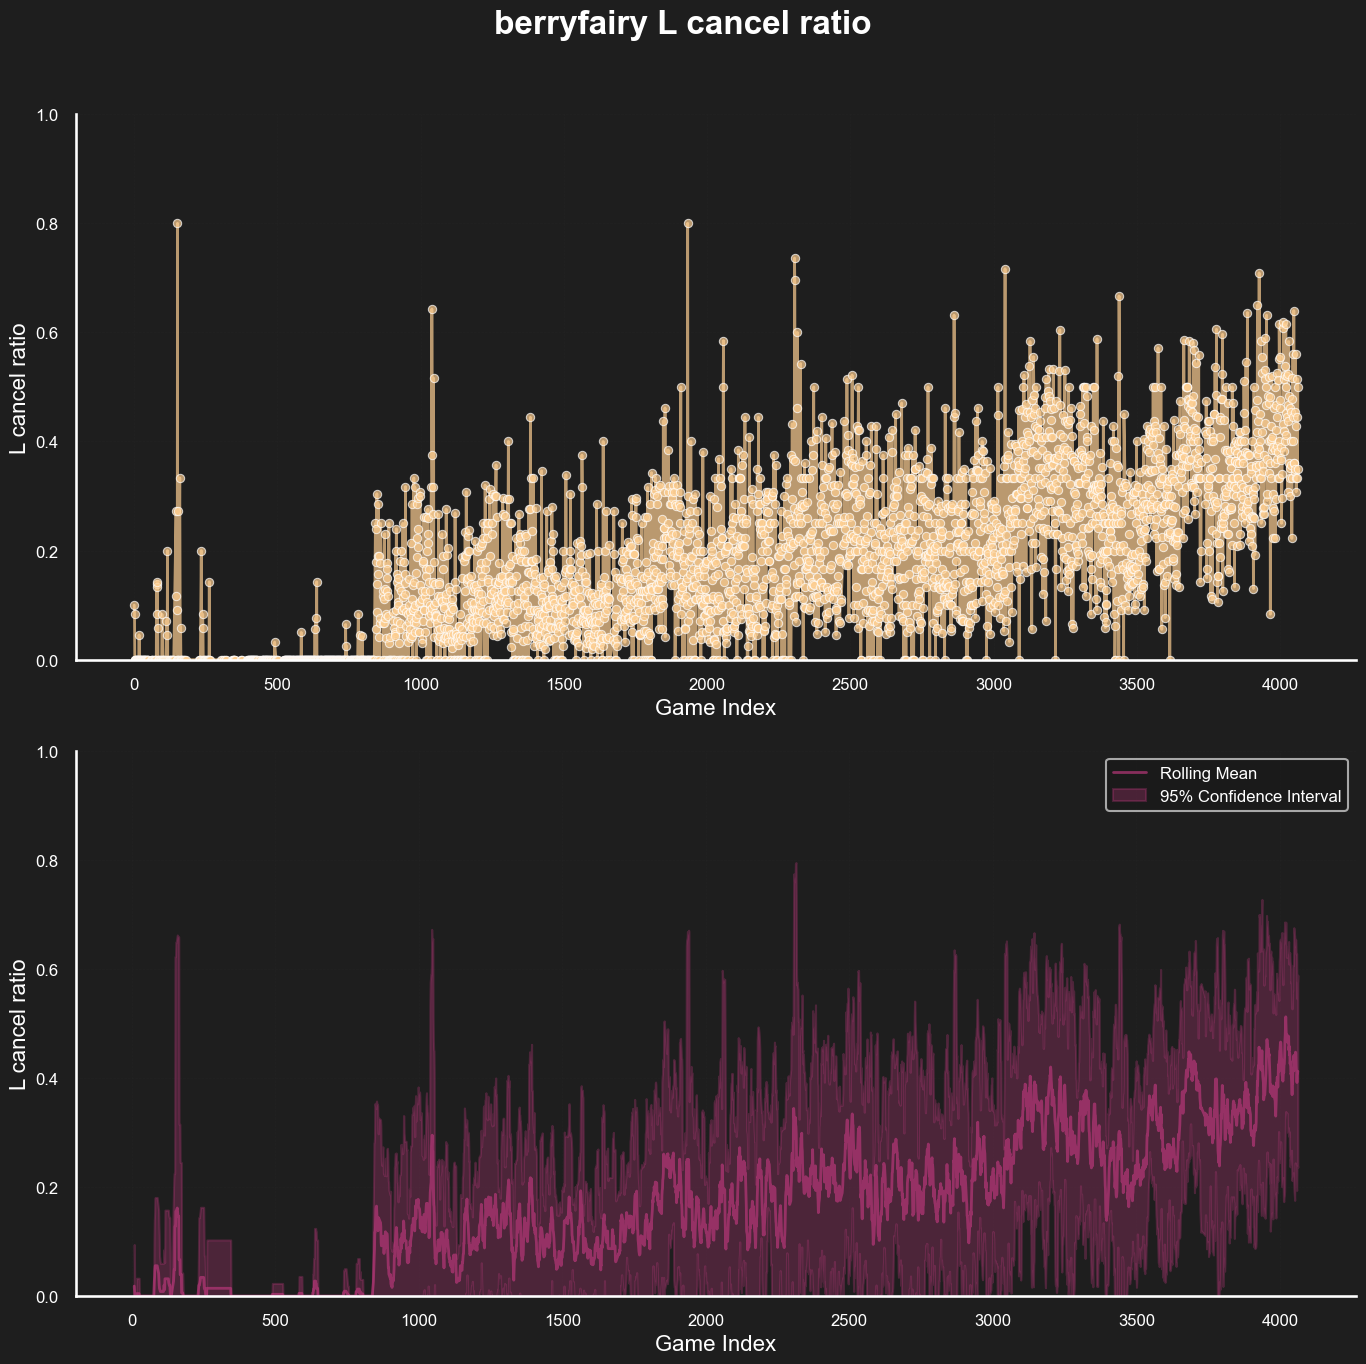

In [12]:
plot_with_moving_average_and_ci(df, 'l_cancel_ratio', mainPlayerName, y_lim=(0,1))

Wavedash

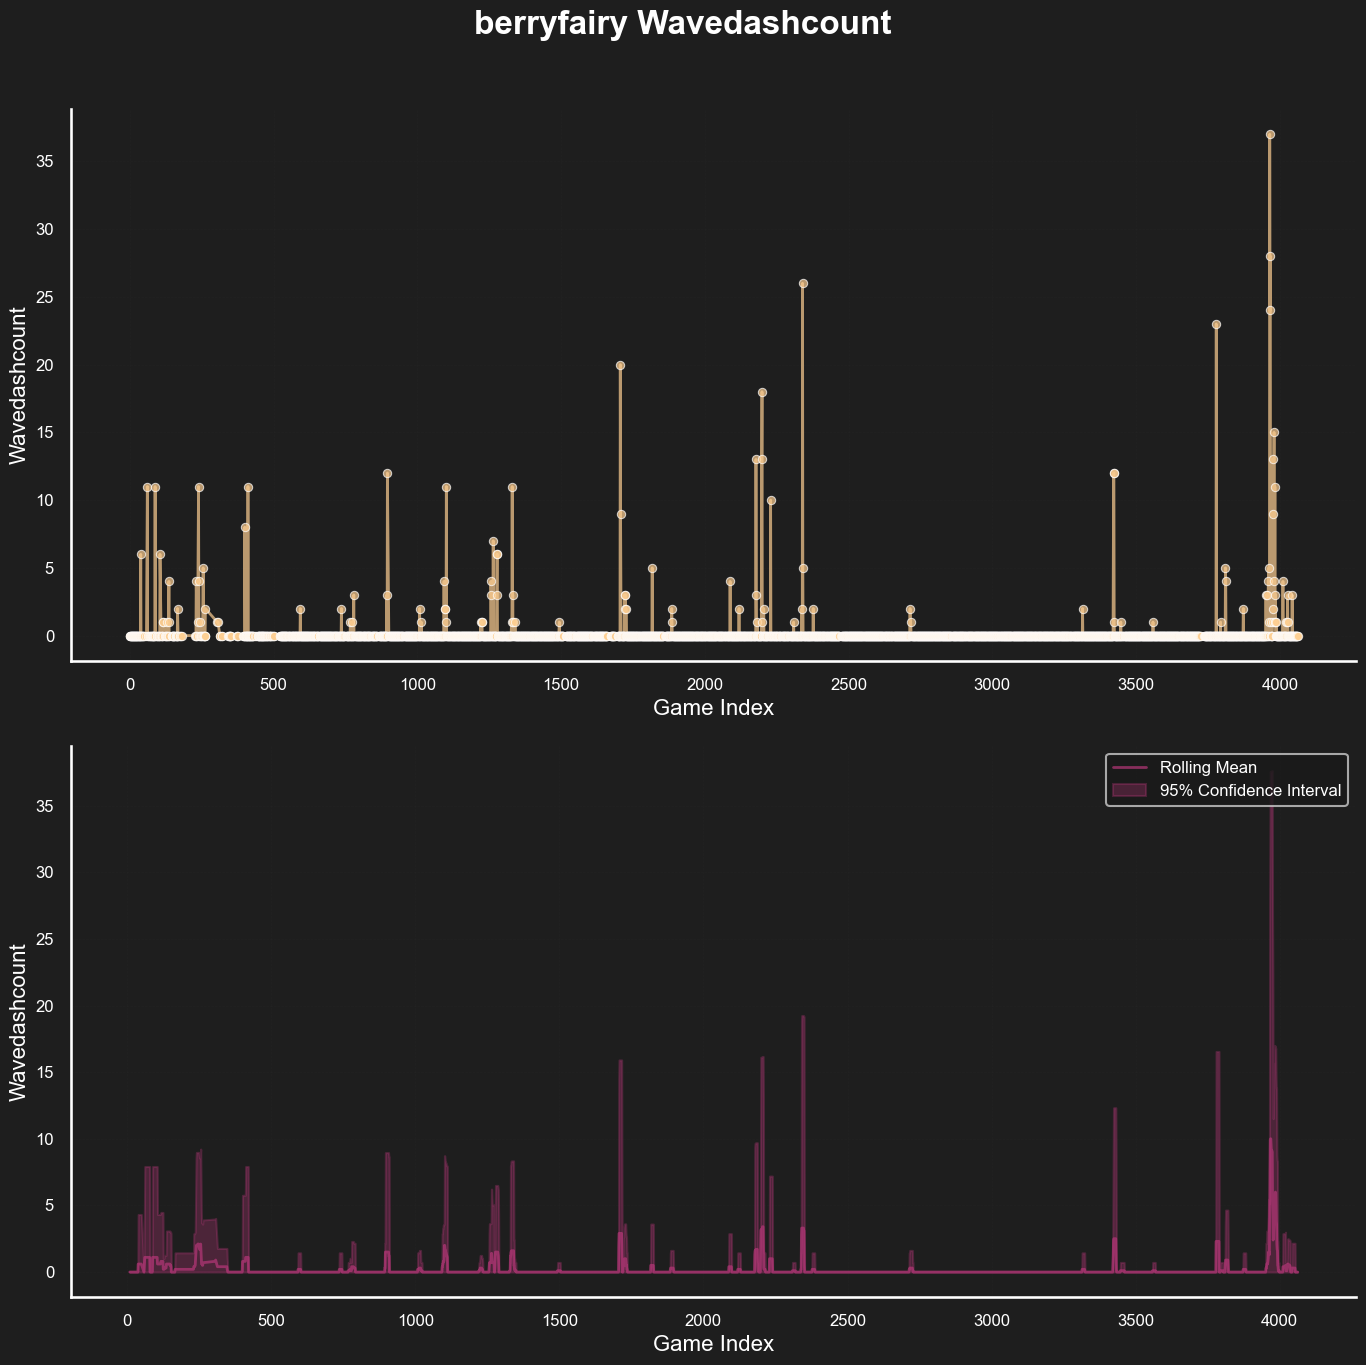

In [13]:
plot_with_moving_average_and_ci(df, 'wavedashCount', mainPlayerName)